## Reinforcement Learning - Assignment 1 - Jack Murray

### Setup Steps

#### Load Packages

In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import matplotlib.pyplot as plt

#### Create a class representing the environment

In [2]:
class Segment: #(gym.Env):
    def __init__(self,numActions,startObservation,p,terminal,done):
        self.numActions = numActions
        self.observation = startObservation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.numActions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2*self.terminal+1)
        self.done = done
    def step(self,action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation!=0
        assert self.observation!=(2*self.terminal)
        observation = self.observation
        done = self.done
        if action==0:
            observation_next = observation + np.random.choice([-1,1],p=[self.p,1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1,1],p=[1-self.p,self.p])
        if observation_next == (2*self.terminal):
            done = True
        elif observation_next == 0:
            done = True
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation,observation_next,action)
        return [self.observation,reward,done]
    def rewards(self,observation,observation_next,action):
        if observation_next==(2*self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    def reset(self):
        observation = self.startObservation
        self.observation = observation
        self.done = False
        return observation

### Question 1 -- Always try to go Right

#### Write a policy -- always move to the right

In [3]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [4]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

In [5]:
env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [6]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [7]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,1.0,2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,2.0,3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,3.0,4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,4.0,5.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,5.0,6.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,6.0,5.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,5.0,6.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,6.0,7.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,7.0,8.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [8]:
v0 = np.sum(dta['beta^t_reward'])
v0

0.08499185925891356

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [9]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [10]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,1.0,2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,2.0,3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,3.0,2.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,2.0,3.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
16725,999.0,15.0,5.0,6.0,1.0,-0.05,0.98,0.738569,-0.036928
16726,999.0,16.0,6.0,7.0,1.0,-0.05,0.98,0.723798,-0.036190
16727,999.0,17.0,7.0,8.0,1.0,-0.05,0.98,0.709322,-0.035466
16728,999.0,18.0,8.0,9.0,1.0,-0.05,0.98,0.695135,-0.034757


#### Group by episode to sum the discounted realized rewards for each episode

In [11]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,0.191578
1.0,0.302560
2.0,-0.300785
3.0,0.302560
4.0,0.084992
...,...
995.0,-0.115686
996.0,0.302560
997.0,0.302560


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [12]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,0.061631
std,0.261479
min,-1.089927
1%,-0.703081
5%,-0.471514
10%,-0.300785
25%,-0.115686
50%,0.084992
75%,0.302560


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

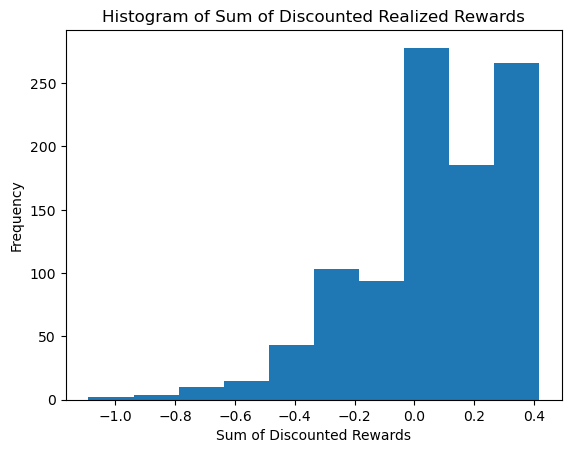

In [13]:
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [14]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.8,terminal=10,done=False)
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [15]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
1,-9.0,1.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
2,-9.0,1.0,1.0,-8.0,-9.0,1.0,-0.05,0.98,0.980000,-0.049000
3,-9.0,1.0,2.0,-9.0,-10.0,1.0,-1.00,0.98,0.960400,-0.960400
4,-9.0,2.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
...,...,...,...,...,...,...,...,...,...,...
305491,9.0,996.0,5.0,8.0,9.0,1.0,-0.05,0.98,0.903921,-0.045196
305492,9.0,996.0,6.0,9.0,10.0,1.0,1.00,0.98,0.885842,0.885842
305493,9.0,997.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
305494,9.0,998.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [16]:
grouped = allEpisodes.groupby('initial')['beta^t_reward'].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
grouped

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,23089.0,-0.028640,0.146174,-1.000000,-0.922368,-0.049,-0.04802,-0.043406,-0.037682,-0.032059,-0.027274,-0.023677,0.591395,0.695135
-8.0,27682.0,-0.020145,0.119552,-0.980000,-0.050000,-0.049,-0.04802,-0.043406,-0.037682,-0.032059,-0.027274,-0.023677,0.603465,0.709322
-7.0,27365.0,-0.016955,0.119480,-0.960400,-0.050000,-0.049,-0.04802,-0.044292,-0.038451,-0.032713,-0.028399,-0.024161,0.641171,0.723798
-6.0,26724.0,-0.015091,0.122257,-0.903921,-0.050000,-0.049,-0.04802,-0.044292,-0.038451,-0.033380,-0.028399,-0.024161,0.654256,0.738569
-5.0,24956.0,-0.013208,0.130687,-0.922368,-0.050000,-0.049,-0.04802,-0.044292,-0.039236,-0.034062,-0.028978,-0.024161,0.667608,0.753642
-4.0,23474.0,-0.011027,0.138572,-0.050000,-0.050000,-0.049,-0.04802,-0.045196,-0.040037,-0.034757,-0.029570,-0.024161,0.709322,0.769022
-3.0,21641.0,-0.008209,0.148882,-0.050000,-0.050000,-0.049,-0.04802,-0.045196,-0.040854,-0.036190,-0.030789,-0.023204,0.723798,0.784717
-2.0,19932.0,-0.004771,0.160094,-0.050000,-0.050000,-0.050,-0.04900,-0.046118,-0.041687,-0.036928,-0.031417,0.410353,0.769022,0.800731
-1.0,18217.0,-0.000710,0.172438,-0.050000,-0.050000,-0.050,-0.04900,-0.046118,-0.041687,-0.037682,-0.032059,0.591395,0.784717,0.817073


In [17]:
allEpisodes.initial.value_counts(sort = False) # in the hw example these are 1000 each, not sure what's happening

-9.0    23089
-8.0    27682
-7.0    27365
-6.0    26724
-5.0    24956
-4.0    23474
-3.0    21641
-2.0    19932
-1.0    18217
 0.0    16604
 1.0    15256
 2.0    13346
 3.0    11910
 4.0    10064
 5.0     8386
 6.0     6818
 7.0     4934
 8.0     3438
 9.0     1660
Name: initial, dtype: int64